Set-up:

In [1]:
import json
import jax.numpy as jnp
import surrojax_gp
import matplotlib as mpl
import matplotlib.pyplot as plt

In [2]:
# Plot settings:
mpl.rcParams['figure.dpi'] = 200

Load data:

In [3]:
def load_beam_data(file_dir):
    with open(file_dir, 'r') as f:
        data = json.load(f)
    x = jnp.stack([jnp.array(data[key]) for key in ('E', 'y_rot')], axis=-1)
    y = jnp.array(jnp.array(data['end_disp'])).reshape(-1,1)
    return {'x': x, 'y': y}

def scale_data(train_data, test_data):
    for key in ['x']:
        train_val, test_val = train_data[key], test_data[key]
        combined = jnp.concatenate([train_val, test_val], axis=0)
        min_val, max_val = jnp.min(combined,axis=0), jnp.max(combined,axis=0)
        train_data[key] = (train_val-min_val)/(max_val-min_val)
        test_data[key] = (test_val-min_val)/(max_val-min_val)
    return train_data, test_data

# def scale_data(train_data, test_data):
#     for key in train_data.keys():
#         train_val, test_val = train_data[key], test_data[key]
#         combined = jnp.concatenate([train_val, test_val], axis=0)
#         min_val, max_val = jnp.min(combined,axis=0), jnp.max(combined,axis=0)
#         train_data[key] = (train_val-min_val)/(max_val-min_val)
#         test_data[key] = (test_val-min_val)/(max_val-min_val)
#     return train_data, test_data

# Load and scale data:
beam_training_data = load_beam_data('nonlinear_beam_train.json')
beam_test_data = load_beam_data('nonlinear_beam_test.json')
# beam_training_data, beam_test_data = scale_data(beam_training_data, beam_test_data)

Define and train Gaussian process model:

In [4]:
def kernel(x_1, x_2, params):
    lengths = jnp.array([params[f"length_{i}"] for i in range(2)])
    inv_lengths = jnp.diag(lengths**(-1))
    ln_k_d = -0.5*(x_1 - x_2).T @ inv_lengths @ (x_1 - x_2) 
    return params["const"]*jnp.exp(ln_k_d)
# constraints = {"length_0": {">": 10**-2, "<": 1}, 
#                "length_1": {">": 10**-2, "<": 1}, 
#                "const": {">": 10**-2, "<": 10**3}}
constraints = {"length_0": {">": 10**-1, "<": 10**3}, 
               "length_1": {">": 10**-1, "<": 10**3}, 
               "const": {">": 10**-1, "<": 10**3}}
beam_gp = surrojax_gp.create_gp(kernel, beam_training_data['x'], beam_training_data['y'], constraints)

269.44156
255.88495
197.58173
201.56076
208.90656
187.93982
187.8424
192.8039
198.49515
187.8424
186.3306
196.66989
192.45514
186.3306
186.3306
186.3306
186.3306
186.3306
186.3306
186.3306
186.3306
186.3306
186.3306
186.3306
186.3306
186.3306
186.3306
186.3306
186.3306
      fun: array(186.33059692)
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([-0.00704992, -0.28027868, -0.09140782])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 29
      nit: 6
     njev: 29
   status: 0
  success: True
        x: array([434.80182337,  65.04452632, 554.04995001])
1480.1056
1355.802
1047.1589
367.8854
399.04544
342.39917
213.38611
252.45667
3384.1575
213.38611
213.38611
213.38611
213.38611
213.38611
213.38611
213.38611
213.38611
213.38611
213.38611
213.38611
213.38611
213.38611
213.38611
      fun: array(213.3861084)
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([-0.03049245,  0.60875344, -0.1365041 ])
  message: 'CONVERGEN

Save this Gaussian process model:

In [161]:
surrojax_gp.save_gp(beam_gp, "nonlinear_beam_gp")

Define plotting functions:

In [10]:
def plot_data(x, y, z, grid_shape, z_label, z_lims=None, train_pts=None, test_pts=None, num_levels=1000, num_ticks=6):
    if z_lims is None:
        z_lims = (jnp.min(z), jnp.max(z))
    levels = jnp.linspace(z_lims[0], z_lims[1], num_levels)
    # Reshape inputs:
    x, y, z = x.reshape(grid_shape), y.reshape(grid_shape), z.reshape(grid_shape)
    # Create surface plot:
    fig, ax = plt.subplots()
    contour_fig = ax.contourf(x, y, z, levels=levels, cmap='coolwarm')
    ticks = jnp.linspace(z_lims[0], z_lims[1], num_ticks)
    cbar = fig.colorbar(contour_fig, ticks=ticks)
    cbar.set_label(z_label, rotation=270, labelpad=15)
    ax.set_xlabel("Normalised Stiffness")
    ax.set_ylabel('Normalised Beam Angle')
    fig.patch.set_facecolor('white')
    if train_pts is not None:
        plt.plot(train_pts['x'][:,0], train_pts['x'][:,1], 'x', color='black', markersize=3)
    if test_pts is not None:
        plt.plot(test_pts['x'][:,0], test_pts['x'][:,1], 'x', color='green', markersize=3)
    plt.show()

def create_pointgrid(x, y, num_x, num_y):
    x_lims = (jnp.min(x), jnp.max(x))
    y_lims = (jnp.min(y), jnp.max(y))
    # Create list of points:
    x_pts = jnp.linspace(jnp.atleast_1d(x_lims[0]), jnp.atleast_1d(x_lims[1]), num_x)
    y_pts = jnp.linspace(jnp.atleast_1d(y_lims[0]), jnp.atleast_1d(y_lims[1]), num_y)
    # Create grid of points:
    x_grid, y_grid = jnp.meshgrid(x_pts.squeeze(), y_pts.squeeze())
    # Store input:
    pts = {'E': x_grid.flatten(), 
           'y_rot': y_grid.flatten(), 
           'x': jnp.stack([x_grid.flatten(), y_grid.flatten()], axis=1)}
    return pts    

Plot GP:

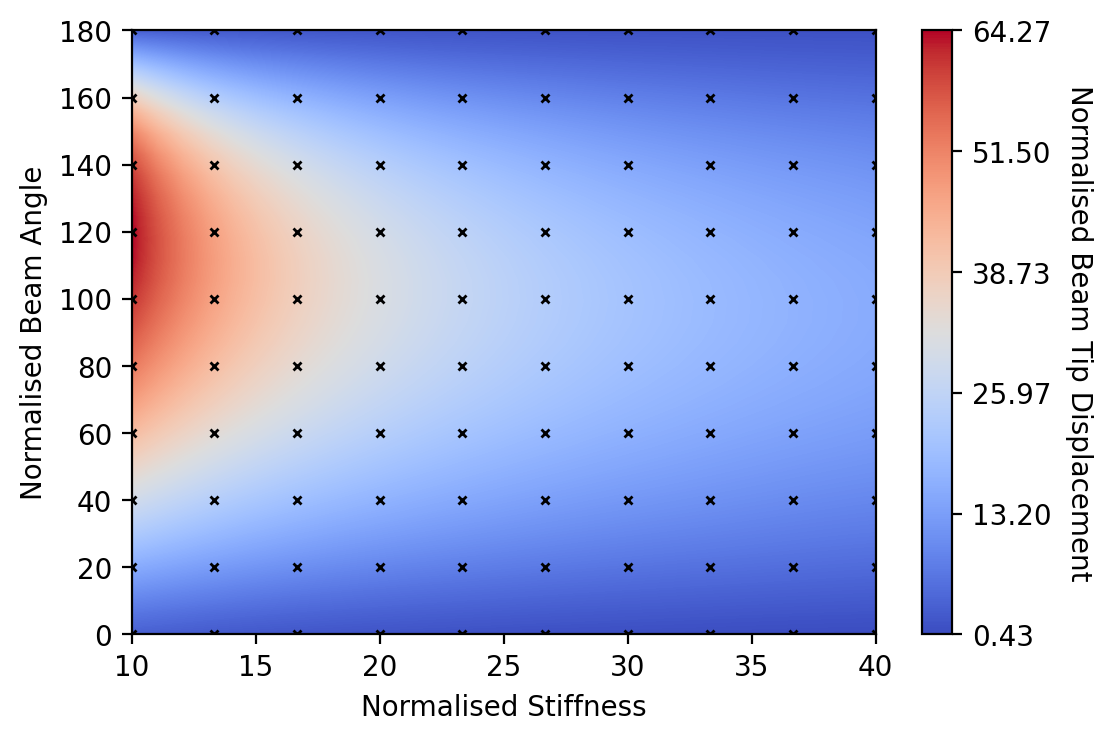

In [11]:
# Plot predictions:
num_x = num_y = 30
pred_pts = create_pointgrid(x=beam_training_data['x'][:,0], y=beam_training_data['x'][:,1], num_x=num_x, num_y=num_y)
gp_pred = beam_gp.predict(pred_pts['x'])
grid_shape = (num_y, num_x)
plot_data(x=pred_pts['E'], y=pred_pts['y_rot'], z=gp_pred['mean'], z_label='Normalised Beam Tip Displacement',
          grid_shape=(num_y, num_x), train_pts=beam_training_data)

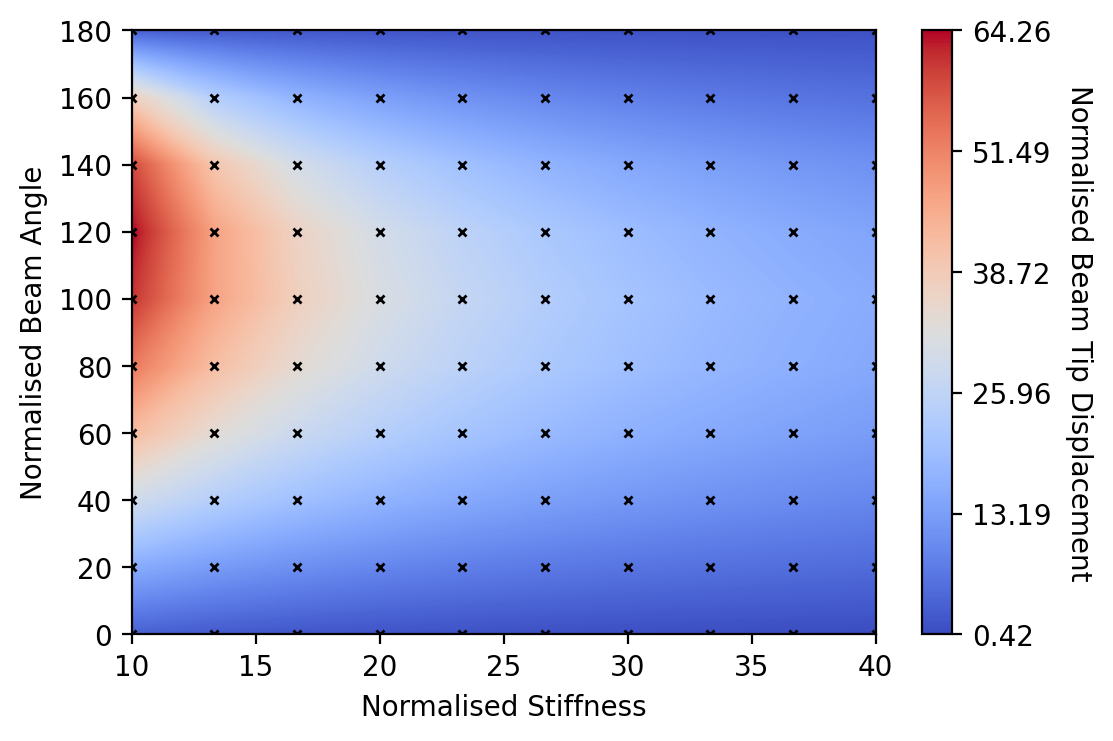

In [12]:
# Plot original data:
E_train = beam_training_data['x'][:,0]
y_rot_train = beam_training_data['x'][:,1]
end_disp_train = beam_training_data['y']
num_y = num_x = 10
plot_data(x=E_train, y=y_rot_train, z=end_disp_train, z_label='Normalised Beam Tip Displacement', 
          grid_shape=(num_y, num_x),  train_pts=beam_training_data)

Test data comparison:

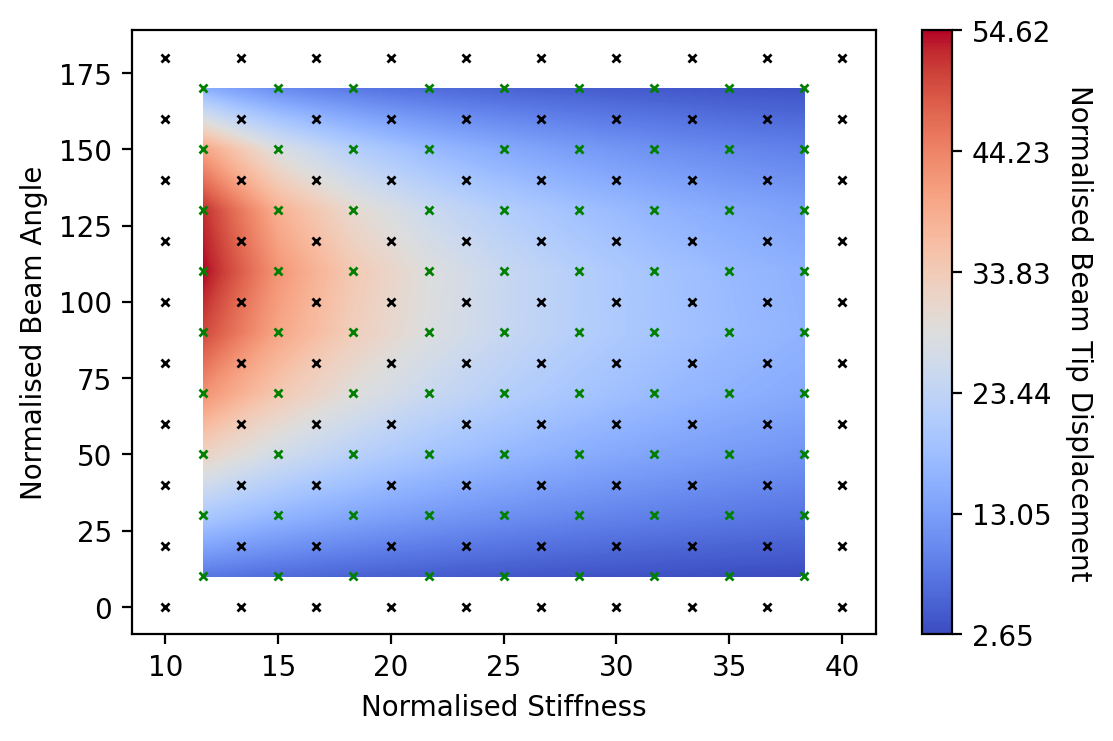

In [13]:
gp_pred = beam_gp.predict(beam_test_data['x'])
plot_data(x=beam_test_data['x'][:,0], y=beam_test_data['x'][:,1], z=gp_pred['mean'], z_label='Normalised Beam Tip Displacement', 
          grid_shape=(9,9), train_pts=beam_training_data, test_pts=beam_test_data)

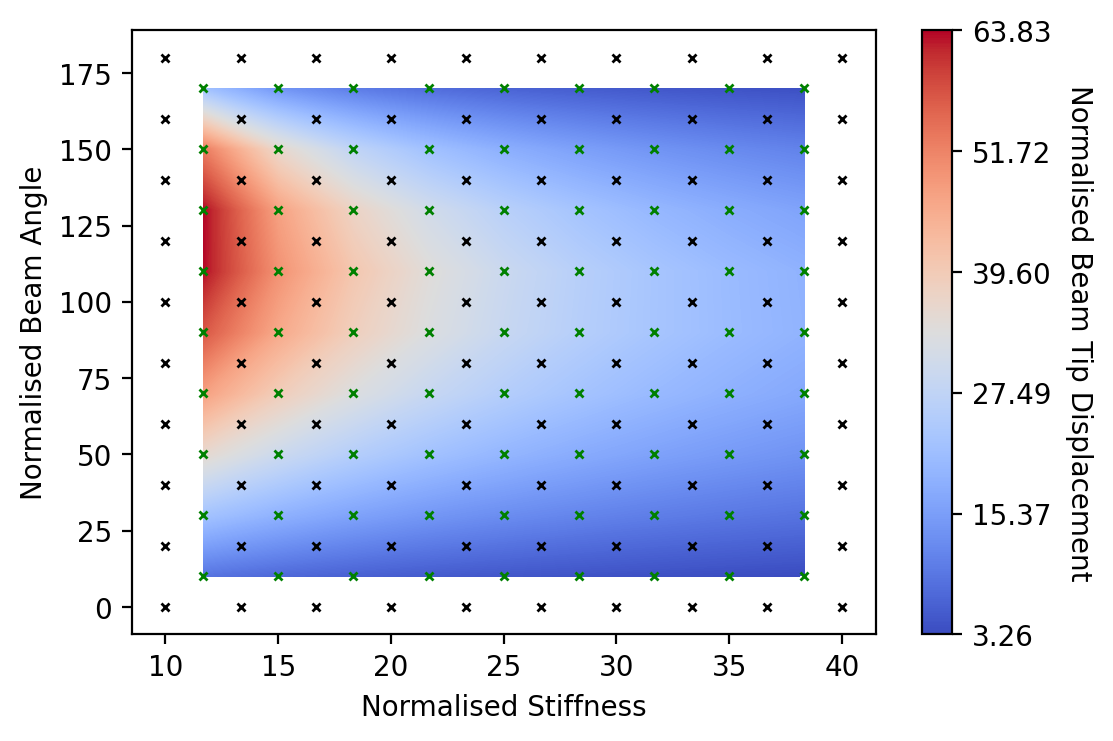

In [14]:
plot_data(x=beam_test_data['x'][:,0], y=beam_test_data['x'][:,1], z=beam_test_data['y'], z_label='Normalised Beam Tip Displacement', 
          grid_shape=(9,9), train_pts=beam_training_data, test_pts=beam_test_data)

Percentage difference:

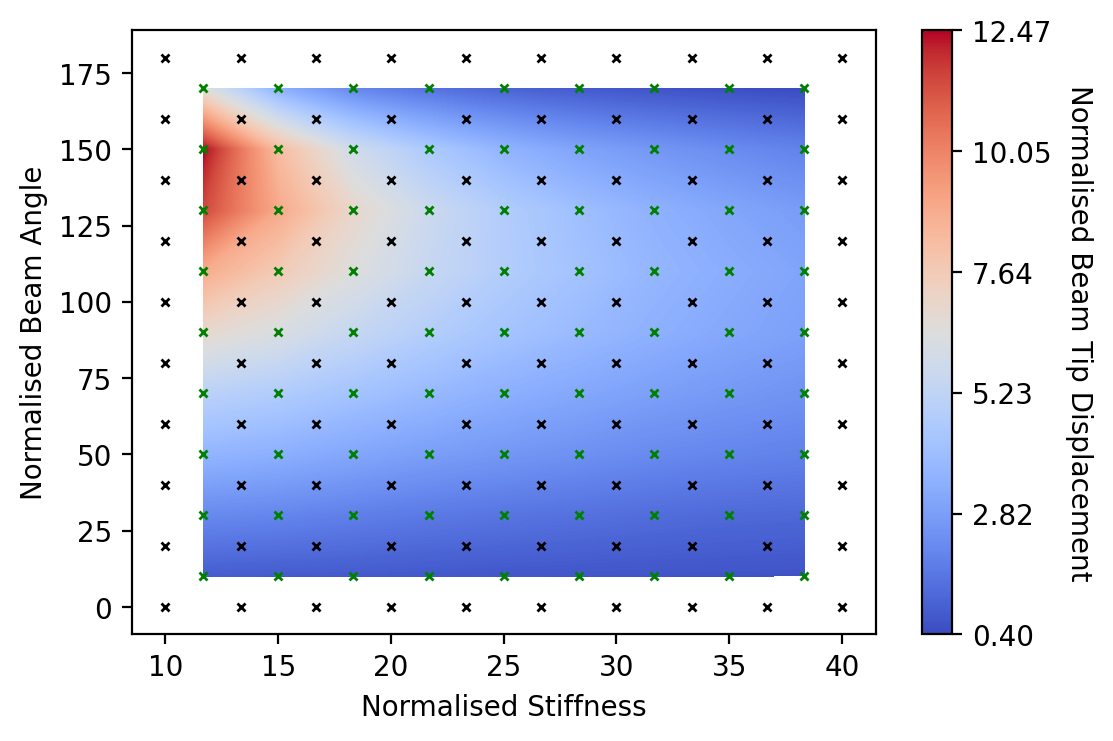

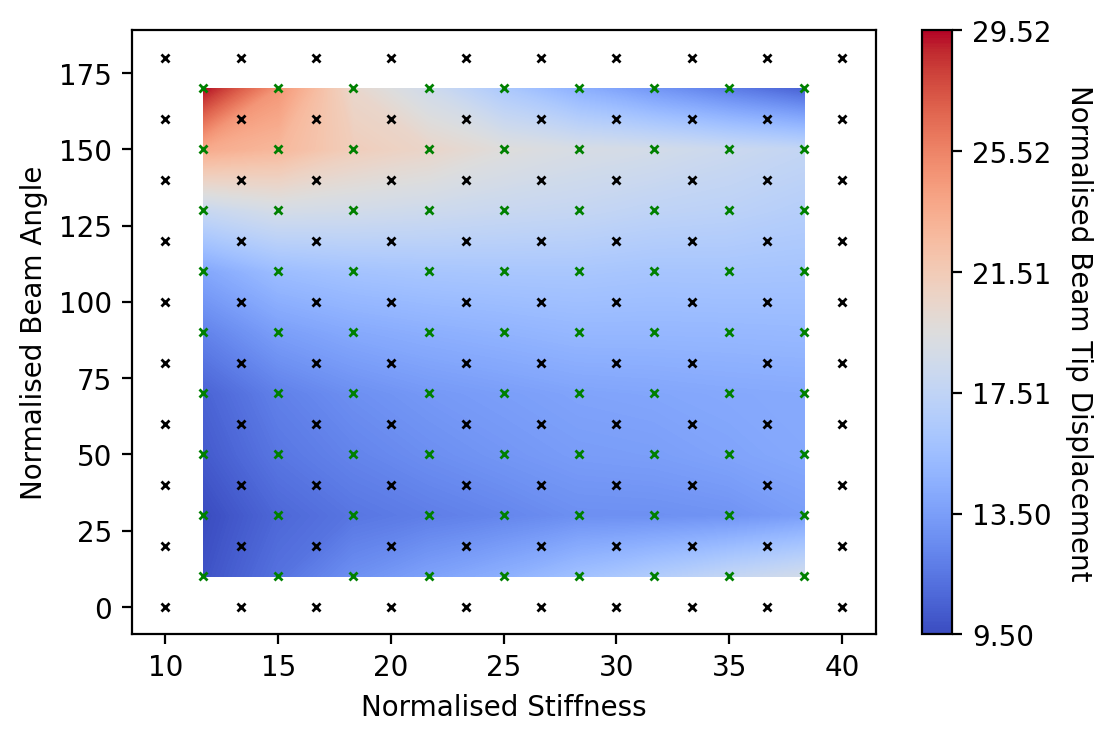

In [19]:
abs_diff = jnp.abs(gp_pred['mean'] - beam_test_data['y'].squeeze())
pct_diff = 100*jnp.abs(gp_pred['mean'] - beam_test_data['y'].squeeze())/beam_test_data['y'].squeeze()
plot_data(x=beam_test_data['x'][:,0], y=beam_test_data['x'][:,1], z=abs_diff, z_label='Normalised Beam Tip Displacement', 
          grid_shape=(9,9), train_pts=beam_training_data, test_pts=beam_test_data)
plot_data(x=beam_test_data['x'][:,0], y=beam_test_data['x'][:,1], z=pct_diff, z_label='Normalised Beam Tip Displacement', 
          grid_shape=(9,9), train_pts=beam_training_data, test_pts=beam_test_data)

Gradient predictions:

In [109]:
gp_pred['mean'].shape

(81,)

In [121]:
jnp.abs(gp_pred['mean'] - beam_test_data['y'].squeeze())/beam_test_data['y'].squeeze()

DeviceArray([0.09271816, 0.12498828, 0.10645958, 0.09630378, 0.11228483,
             0.14095452, 0.1822915 , 0.24461316, 0.24934383, 0.08554068,
             0.12208696, 0.1213471 , 0.11559864, 0.1236411 , 0.14934677,
             0.19229697, 0.25109646, 0.274268  , 0.09349092, 0.1177367 ,
             0.13485305, 0.1380184 , 0.13935019, 0.15200831, 0.18547264,
             0.23163533, 0.25458837, 0.13448536, 0.10862236, 0.13198861,
             0.15262489, 0.15871854, 0.16401435, 0.17109028, 0.18277434,
             0.13794987, 0.20980433, 0.10461577, 0.1185777 , 0.15214348,
             0.1722287 , 0.17519774, 0.16784546, 0.14315234, 0.05299168,
             0.3004304 , 0.1100579 , 0.1014776 , 0.13285734, 0.1644993 ,
             0.18117903, 0.17774571, 0.14166856, 0.04855247, 0.29700452,
             0.11563916, 0.0987317 , 0.11659019, 0.1506096 , 0.18285026,
             0.19503969, 0.1897968 , 0.1477966 , 0.12652445, 0.12394428,
             0.12936418, 0.12616481, 0.1428645 , 0.